In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

df_train = pd.read_csv('train_final.csv')
df_test = pd.read_csv('test_final.csv')

In [2]:
target = df_train["Y"]
id = df_test["Id"].values

df_train.drop(['Id','Y'],axis=1,inplace=True)
df_test.drop(['Id'],axis=1,inplace=True)

In [3]:
print('Binary features summary statistics')
df_train.describe().T.style.bar(subset = ['mean'], color = 'grey').bar(subset = ['std'],color = 'grey').background_gradient(cmap = 'GnBu')

Binary features summary statistics


,count,mean,std,min,25%,50%,75%,max
2,2603.000000,0.000768,0.027714,0.000000,0.000000,0.000000,0.000000,1.000000
3,2603.000000,0.463312,0.498748,0.000000,0.000000,0.000000,1.000000,1.000000
4,2603.000000,-46.734537,394.284920,-3136.000000,0.000000,0.000000,0.000000,1175.000000
5,2603.000000,0.000768,0.027714,0.000000,0.000000,0.000000,0.000000,1.000000
6,2603.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2603.000000,0.275836,0.447020,0.000000,0.000000,0.000000,1.000000,1.000000
8,2603.000000,0.023434,0.151308,0.000000,0.000000,0.000000,0.000000,1.000000
9,2603.000000,0.000384,0.019600,0.000000,0.000000,0.000000,0.000000,1.000000
10,2603.000000,0.955436,0.206384,0.000000,1.000000,1.000000,1.000000,1.000000
11,2603.000000,0.001921,0.043794,0.000000,0.000000,0.000000,0.000000,1.000000


In [4]:
# drop_zeros = ['6','30','35', '40', '60','80', '90', '101','102', '113', '118', '129', '138', '142','163', '206', '216', '233', '239', '247','250', '253', '259', '305', '307', '315', '322', '323', '333', '350', '364', '120', '208']

# df_train =  df_train.drop(drop_zeros,axis=1)        
# df_test = df_test.drop(drop_zeros,axis=1)

In [5]:
from sklearn import preprocessing

#columns = ['4','63','132', '146', '180','382', '119', '198', '379']
columns = ['4','180',  '379']

scale_train = preprocessing.RobustScaler().fit(df_train[columns])
df_train[columns] = scale_train.transform(df_train[columns])

scale_test = preprocessing.RobustScaler().fit(df_test[columns])
df_test[columns] = scale_test.transform(df_test[columns])

minmax_scale_train = preprocessing.MinMaxScaler().fit(df_train[columns])
df_train[columns] = minmax_scale_train.transform(df_train[columns])

minmax_scale_test = preprocessing.MinMaxScaler().fit(df_test[columns])
df_test[columns] = minmax_scale_test.transform(df_test[columns])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_train, target, test_size=0.33, random_state=1)

In [7]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

para = { 'learning_rate': 0.019, 'iterations': 715, 'depth': 6,  "verbose":0,  "class_weights":[0.55,0.45]}

catboost = CatBoostClassifier(**para)

catboost.fit(x_train, y_train)

y_proba = catboost.predict_proba(x_test)
print(roc_auc_score(y_test, y_proba[:,1]))



y_pred = catboost.predict(x_test)

score = (accuracy_score(y_test, y_pred)) * 100
print("Accuracy score is %.2f%%" % score)

0.8840864278672362
Accuracy score is 85.45%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


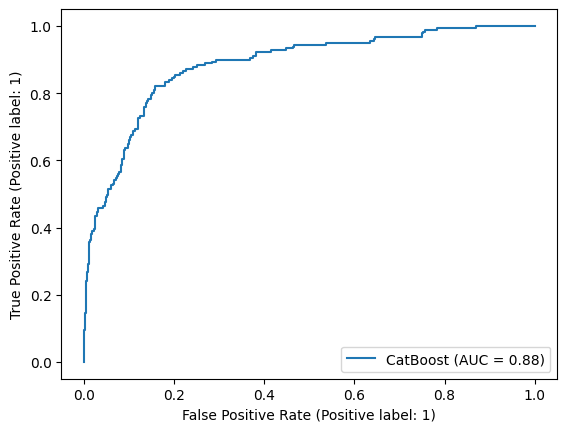

In [9]:
# 0.8830594807755504
# Accuracy score is 85.80%

plot_roc_curve(catboost, x_test, y_test, name = 'CatBoost')

In [10]:
sub_proba = catboost.predict_proba(df_test)
pred_col=np.c_[id,sub_proba[:,1]]

submission = pd.DataFrame(pred_col, columns = ['Id','Y'])
submission["Id"] = submission["Id"].astype("Int32")
submission

,Id,Y
0,2604,0.044798
1,2605,0.054620
2,2606,0.037812
3,2607,0.008457
4,2608,0.653529
...,...,...
3599,6203,0.226014
3600,6204,0.052969
3601,6205,0.011748
3602,6206,0.033664


In [11]:
submission.to_csv('lastday1submission.csv', index=False)

In [ ]:
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
# define the base models
level0 = list()
level0.append(('xg', xgb.XGBClassifier(n_estimators=100)))
level0.append(('cat', CatBoostClassifier(**para)))
# define meta learner model
level1 = CatBoostClassifier(**para)
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)


In [ ]:
model.fit(x_train, y_train)

In [ ]:
plot_roc_curve(model, x_test, y_test, name = 'stack')

In [ ]:
y_proba = model.predict_proba(x_test)
roc_auc_score(y_test, y_proba[:,1])

In [ ]:
# sub_proba = catboost.predict_proba(df_test)
# pred_col=np.c_[id,sub_proba[:,1]]

# submission = pd.DataFrame(pred_col, columns = ['Id','Y'])
# submission["Id"] = submission["Id"].astype("Int32")
# submission


In [ ]:
# submission.to_csv('3submission.csv', index=False)